# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### Данные находятся в трёх файлах:
1. gold_recovery_train.csv — обучающая выборка
2. gold_recovery_test.csv — тестовая выборка
3. gold_recovery_full.csv — исходные данные
<br>
<br>Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
<br>Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
<br>
<br>Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища.

# 1. Подготовка данных

In [1]:
import pandas as pd
df_train = pd.read_csv('gold_recovery_train.csv')
df_test = pd.read_csv('gold_recovery_test.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [2]:
df_train.isna().sum().sort_values(ascending=False).head(10) #кол-во пропусков в признаках

rougher.output.recovery               2573
rougher.output.tail_ag                2250
rougher.output.tail_sol               2249
rougher.output.tail_au                2249
secondary_cleaner.output.tail_sol     1986
rougher.input.floatbank11_xanthate    1904
final.output.recovery                 1521
primary_cleaner.input.sulfate         1307
primary_cleaner.input.depressant      1262
rougher.calculation.au_pb_ratio       1242
dtype: int64

### В обучающем наборе имеются пропуски, в основном у признаков, которые показывают эффективность обогащения и состав хвостов, после обогащения. Т.к. пропусков немного, относительно общего кол-ва признаков, то я просто удалю их и у нас еще останется достаточно данных, чтобы обучить и провалидировать модель.

In [3]:
df_train = df_train.dropna()

In [4]:
df_test.isna().sum().sort_values(ascending=False).head(10) #кол-во пропусков в признаках

rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary_cleaner.state.floatbank3_a_air     34
dtype: int64

### По такому же принципу я удалю пропуски и из тестовой выборки.

In [5]:
df_test = df_test.dropna()

## 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

### для расчета MAE оставим только необходимые столбцы, сделаем для этого новый датасет:

In [6]:
df_rougher_recovery_au = df_train[['rougher.input.feed_au','rougher.output.concentrate_au', 'rougher.output.tail_au','rougher.output.recovery']].copy()

In [7]:
c = df_rougher_recovery_au['rougher.output.concentrate_au'] #доля золота в концентрате, после обогащения
t = df_rougher_recovery_au['rougher.output.tail_au'] #доля золота в хвосте, после обогащения
f = df_rougher_recovery_au['rougher.input.feed_au'] #доля золота в сырье до обогащения

### добавим к этому датасету столбец с эффективность обогащения, посчитаному по формуле

In [8]:
df_rougher_recovery_au['recovery_mae'] = (c*(f-t)) / (f*(c-t)) *100

### воспользуемся библиотекой sklearn и посчитаем среднюю абсолютную ошибку между исходными данными и нашим рассчетом.

In [9]:
from sklearn.metrics import mean_absolute_error
rec_1 = df_rougher_recovery_au['rougher.output.recovery']
rec_2 = df_rougher_recovery_au['recovery_mae']

In [10]:
mae = mean_absolute_error(rec_1, rec_2)
mae

9.555596961987514e-15

### MAE = 9,5 * 10 (в степени минус 15), это значит, что мы имеем ошибку равную ОЧЕНЬ маленькому числу, которое можно считать равным нулю! Если я ничего не путаю, то это нуль с четырнадцатью нулями после запятой :), а следовательно значения объектов для признака rougher.output.recovery рассчитаны верно в тренировочном наборе данных!

## 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

### сначала обозначим переменные с признаками (списки)

In [11]:
train_columns = df_train.columns #список с названиями признаков в обучающем датасете
test_columns = df_test.columns #список с названиями признаков в тестовом датасете

In [12]:
print('кол-во признаков в df_train равно:', len(train_columns))
print('кол-во признаков в df_test равно:', len(test_columns))

кол-во признаков в df_train равно: 87
кол-во признаков в df_test равно: 53


###  напишем цикл, который найдет нам в обучающей выборке признаки, которых нет в тестовой.

In [13]:
train_columns_more = [] # пустой список для добавления признаков
for i in train_columns: # берем i признак из учебного датасета
    if i not in test_columns: #проверяем этот признак на наличие в признаках тестового датасета и если его там нет, то...:
        train_columns_more.append(i) #добавляем этот признак в наш пустой список

In [14]:
print('кол-во признаков в train_columns_more равно:', len(train_columns_more))

кол-во признаков в train_columns_more равно: 34


### 87 - 53 = 34, пока всё верно, недостающие в тестовой выборке признаки мы нашли, теперь надо на них посмотреть. Для этого создадим новый датафрейм, для которого из обучающего возьмем только вышеуказанные признаки

In [15]:
#df_train.info()

In [16]:
df_train_more = pd.DataFrame(data=df_train, columns=train_columns_more)

In [17]:
#df_train_more.info()

### В тестовой выборке нет признаков, которые являются "выходными" значениями (output) на всех этапах обработки руды, что вполне логично, т.к. тестировать модель надо именно на "входящей информации", а это значит, что нельзя использовать эти признаки (output) в обучении модели, т.е. в обучающем дата сете нужно убрать все признаки, которых нет в тестовом датасете. Все недостающие признаки имеют числовой тип float64

### Подготовим тренировочную выборку, удалим из нее лишние признаки. Для этого я также напишу аналогичный цикл, но теперь буду оставлять только те столбцы, которые есть в тестовой выборке. Возможно это можно сделать быстрее и проще, но моих знаний хватило только на это :))

In [18]:
df_train_little = [] # пустой список для добавления признаков

for i in train_columns: # берем i признак из учебного датасета
    if i in test_columns: #проверяем этот признак на наличие в признаках тестового датасета и если он там есть, то...:
        df_train_little.append(i) #добавляем этот признак в наш пустой список

### Добавим к списку c признаками название целевых признаков

In [19]:
df_train_little = df_train_little + ['rougher.output.recovery','final.output.recovery']

In [20]:
#df_train_little

In [21]:
df_train = pd.DataFrame(data=df_train, columns=df_train_little)

### Подтянем в тестовую выборку целевые признаки из полного датасета

In [22]:
df_full = pd.read_csv('gold_recovery_full.csv')
df_full = df_full.dropna()

In [23]:
df_test = df_test.merge(df_full[['rougher.output.recovery','final.output.recovery','primary_cleaner.input.sulfate']], on='primary_cleaner.input.sulfate', how='left')

### Еще раз дропним объекты с пропусками

In [24]:
df_test = df_test.dropna()

## Первичная обработка данных проведена, далее следует анализ данных, поэтому пока не буду готовить тренировочную выборку к обучению модели, сделаю это в 3-м пункте.

# 2. Анализ данных

## 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

### Для анализа воспользуемся полной выборкой и возьмём из нее только столбцы с концентрацией металлов. Чтобы не искать их вручную, напишем цикл.

In [25]:
metall = ['au','ag','pb']
density = []
for i in metall:              #берем i металл
    for j in df_full.columns: #берем j столбец из нашей таблицы
        if i in j:            #проверяем содержится ли название металла в названии столбца и если да, то
            density.append(j) #добавляем этот столбец в наш список

In [26]:
#df_full.median().head(60)

### Соберем новый датафрейм с выбранными столбцами

In [27]:
df_metall = pd.DataFrame(data=df_full, columns=density)

### Удалим признаки с хвостами и калькуляциями

In [28]:
df_metall = df_metall.drop(['final.output.tail_ag','final.output.tail_au','final.output.tail_pb','primary_cleaner.output.tail_ag','primary_cleaner.output.tail_au','primary_cleaner.output.tail_pb','rougher.calculation.au_pb_ratio','rougher.calculation.floatbank10_sulfate_to_au_feed','rougher.calculation.floatbank11_sulfate_to_au_feed','rougher.calculation.sulfate_to_au_concentrate','rougher.output.tail_ag','rougher.output.tail_au','rougher.output.tail_pb','secondary_cleaner.output.tail_ag','secondary_cleaner.output.tail_au','secondary_cleaner.output.tail_pb'], axis=1)

### Для каждого металла сделаем отдельную таблицу

In [29]:
df_metall_ag = df_metall[['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]
df_metall_au = df_metall[['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']]
df_metall_pb = df_metall[['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]

In [30]:
import matplotlib.pyplot as plt

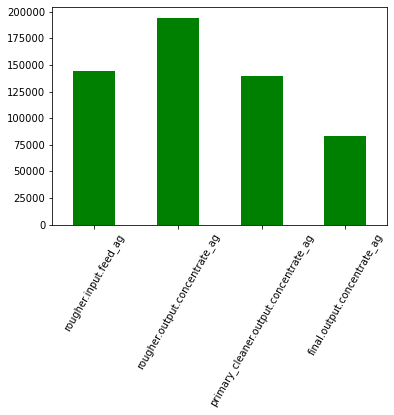

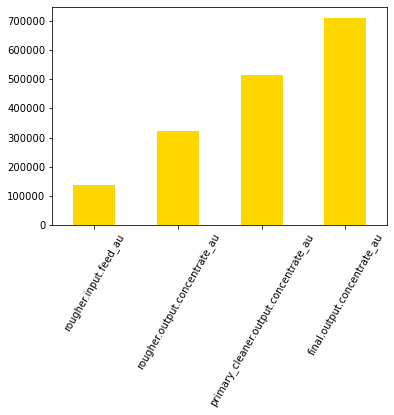

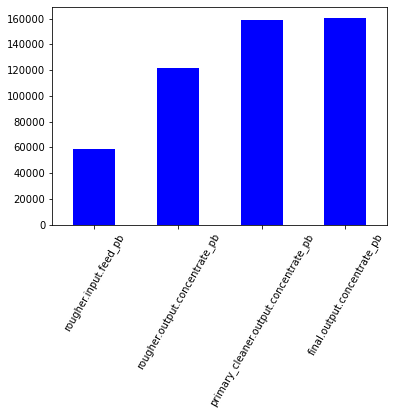

In [31]:
df_metall_ag.sum().plot(kind='bar', rot=60, color='green')
plt.show()
df_metall_au.sum().plot(kind='bar', rot=60, color='gold')
plt.show()
df_metall_pb.sum().plot(kind='bar', rot=60, color='blue')
plt.show()

## По графикам видно, что после обогащения повышается концентрация металлов, но далее можно наблюдать уже различное поведение. К примеру концентрация золота и свинца постепенно повышается после каждой последующей очистки, а концентрация серебра наоборот понижается. Следовательно можно сделать вывод, что производство настроено на максимальное сохранение золота из исходной руды. Свинец тоже хорошо сохраняется, вряд ли это делается специально, скорее просто такие погрешности производства, не думаю, что этот металл является ценным в промышленности)) А вот концентрация серебра снижается после каждой последующей очистки, но в целом, это снижение не такое критическое и также сязанно с погрешностями в стадиях очистки.

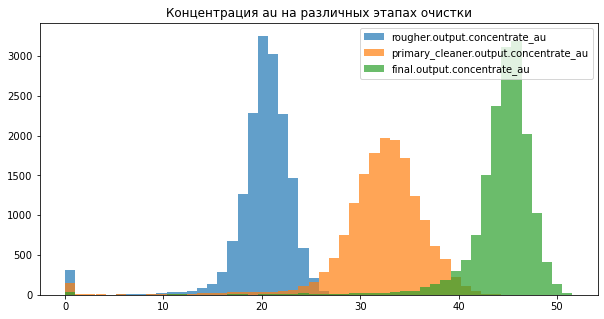

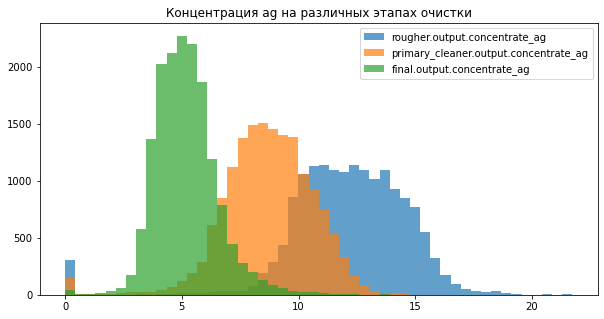

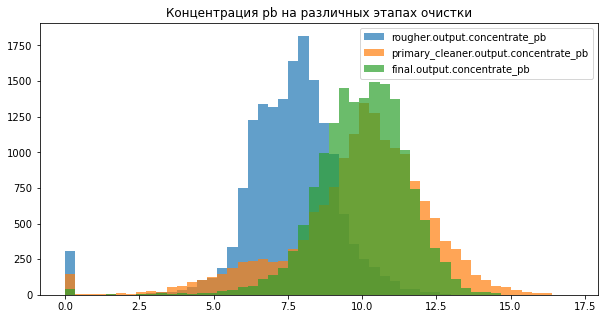

In [32]:
list_metal = ['au','ag','pb']
for metal in list_metal:
    rougher_output = 'rougher.output.concentrate_' + metal
    primary_cleaner_output = 'primary_cleaner.output.concentrate_' + metal
    final_output ='final.output.concentrate_' + metal
    
    (df_full[[rougher_output,
                primary_cleaner_output, 
                final_output]]
     .plot(kind='hist', bins=50, linewidth=3, alpha=0.7, figsize=(10, 5))
    )
    #границы осей
#    plt.xlim(0,55)
#    подписи осей графика
    plt.xlabel('')
    plt.ylabel('')
#    заголовок
    plt.title('Концентрация ' + metal + ' на различных этапах очистки')
    plt.show()

## 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

### Для начала посмотрим на ящики с усами

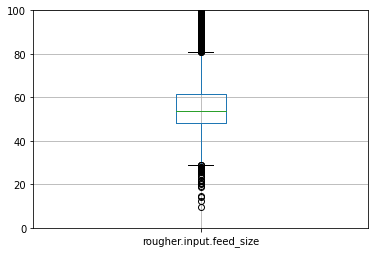

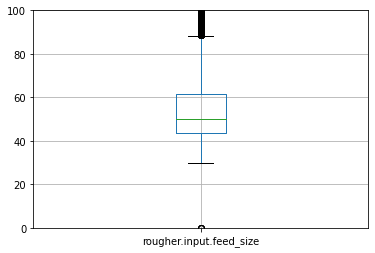

In [33]:
df_train.boxplot(column='rougher.input.feed_size')
plt.ylim(0,100)
plt.show()
df_test.boxplot(column='rougher.input.feed_size')
plt.ylim(0,100) 
plt.show()

### Судя по ящикам мы имеем довольно равные распределения. Единственное визуальное отличие, которое сразу видно, это отсутствие в тестовой выборке маленьких выбросов. Посмотрим на числовые показатели в  распределение данного признака с помощью функции describe() и посмотрим на гистограммы.

In [34]:
print(df_train['rougher.input.feed_size'].describe())
print(df_test['rougher.input.feed_size'].describe())

count    11017.000000
mean        57.215128
std         18.913146
min          9.659576
25%         48.397242
50%         53.843359
75%         61.461770
max        484.967466
Name: rougher.input.feed_size, dtype: float64
count    4981.000000
mean       54.977301
std        14.735167
min         0.046369
25%        43.822479
50%        50.145364
75%        61.704392
max       190.837404
Name: rougher.input.feed_size, dtype: float64


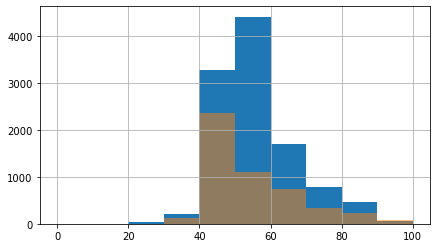

In [35]:
df_train['rougher.input.feed_size'].hist(bins=10, range=(0, 100), figsize=(7, 4))
df_test['rougher.input.feed_size'].hist(bins=10, range=(0, 100), figsize=(7, 4), alpha=0.5)

## Гистограммы практически аналогичны, только в тестовой выборке меньше значений, поэтому и кол-во объектов на коричневой гистограмме меньше. Разумеется распределения имеют различия, но они незначительны и думаю, что проблем в обучении модели не возникнет.

## 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

###  Добавим колонки с суммарной концентрацией всех металлов на разных стадиях

In [36]:
#df_full.info()

In [37]:
# Концентрация в сырье
df_full['rougher.input.feed_all'] = (
df_full['rougher.input.feed_ag'] + 
df_full['rougher.input.feed_pb'] + 
df_full['rougher.input.feed_sol']+
df_full['rougher.input.feed_au']
)

In [38]:
# Концентрация после обогащения
df_full['rougher.output.concentrate_all'] = (
df_full['rougher.output.concentrate_ag'] + 
df_full['rougher.output.concentrate_pb'] + 
df_full['rougher.output.concentrate_sol']+
df_full['rougher.output.concentrate_au']
)

In [39]:
# Концентрация после 1-го этапа очистки
df_full['primary_cleaner.output.concentrate_all'] = (
df_full['primary_cleaner.output.concentrate_ag'] + 
df_full['primary_cleaner.output.concentrate_pb'] + 
df_full['primary_cleaner.output.concentrate_sol']+
df_full['primary_cleaner.output.concentrate_au']
)

In [40]:
# финальная концентрация после 2-го этапа очистки
df_full['final.output.concentrate_all'] = (
df_full['final.output.concentrate_ag'] + 
df_full['final.output.concentrate_pb'] + 
df_full['final.output.concentrate_sol']+
df_full['final.output.concentrate_au']
)

In [41]:
df_full_sum = df_full[['rougher.input.feed_all','rougher.output.concentrate_all','primary_cleaner.output.concentrate_all','final.output.concentrate_all']]

In [42]:
df_full_sum

,rougher.input.feed_all,rougher.output.concentrate_all,primary_cleaner.output.concentrate_all,final.output.concentrate_all
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...
22711,53.415050,70.781325,59.001692,68.098589
22712,53.696482,70.539603,59.703912,68.274362
22713,54.589604,55.376330,59.561096,68.226068
22714,54.027355,69.201689,57.216686,68.200449


### Построим гистограммы

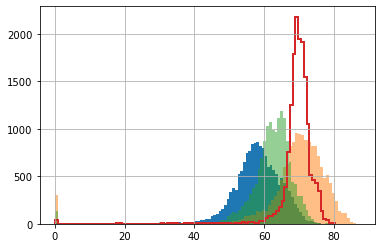

In [43]:
df_full_sum['rougher.input.feed_all'].hist(bins=100)
df_full_sum['rougher.output.concentrate_all'].hist(bins=100, alpha=0.5)
df_full_sum['primary_cleaner.output.concentrate_all'].hist(bins=100, alpha=0.5)
df_full_sum['final.output.concentrate_all'].hist(bins=100, histtype='step', linewidth=2)

- сырьё (синий)
- после обогащения (оранжевый)
- после 1-го этапа очистки (зеленый)
- после 2-го этапа очистки (красный)


### Есть небольшое кол-во выбросов, что вполне нормально, для наглядности можно поближе посмотреть на распределения, добавим параметр range)

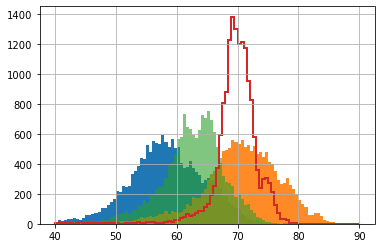

In [44]:
df_full_sum['rougher.input.feed_all'].hist(bins=100, alpha=1, range=(40, 90))
df_full_sum['rougher.output.concentrate_all'].hist(bins=100, alpha=0.9, range=(40, 90))
df_full_sum['primary_cleaner.output.concentrate_all'].hist(bins=100, alpha=0.6, range=(40, 90))
df_full_sum['final.output.concentrate_all'].hist(bins=100, histtype='step', linewidth=2, range=(40, 90))

## Все распределения нормальные, есть выбросы, но это не критично, каких-то серьёзных аномалий в распределениях я не заметил :) Получившиеся гистограммы я могу интерпритировать следующим образом. После обогащения увеличиается концентрация металлов в исходном сырье, видимо поэтому этот процесс и называется "обогащением", после первого этапа очистки концентрация снижается, т.к. теряется часть металлов, а после второго этапа концентрация становится максимальной, т.к. по максимуму удаляются все ненужные материалы, при этом график сужается и вытягивается вверх, это говорит о том, что теряется разнообразие значений в распределении и уменьшается стандартное отклонение, наверно это тоже хорошо :)

In [45]:
df_full_sum['rougher.output.concentrate_all'].describe()

count    16094.000000
mean        68.805821
std         12.095202
min          0.000000
25%         66.643291
50%         70.701213
75%         74.763404
max         87.273435
Name: rougher.output.concentrate_all, dtype: float64

In [46]:
df_full_sum['final.output.concentrate_all'].describe()

count    16094.000000
mean        69.367841
std          6.038211
min          0.000000
25%         68.372986
50%         69.943177
75%         71.669414
max         80.210644
Name: final.output.concentrate_all, dtype: float64

# 3. Модель

##  Напишите функцию для вычисления итоговой sMAPE

In [47]:
# import numpy
# def smape(answer, predict):
#     n = 0
#     for i in range(len(answer)):
#         s = (( abs(answer[i] - predict[i]) ) / ( ( abs(answer[i])  +  abs(predict[i]) ) / 2 )) * 100
#         n += s
#     k = n / len(answer)
#     return k

In [48]:
import numpy
def smape(answer, predict):
    s = ((( abs(answer - predict) ) / ( ( abs(answer)  +  abs(predict) ) / 2 )) * 100).sum() / len(answer)
    return s

#### заранее протестировал функцию на самопальных сериесах, кажется работает :)

## 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

### Отделим целевые признаки

In [49]:
features_train = df_train.drop(['rougher.output.recovery', 'final.output.recovery','date'], axis=1)
target_train_rougher = df_train['rougher.output.recovery']
target_train_final = df_train['final.output.recovery']
features_test = df_test.drop(['rougher.output.recovery', 'final.output.recovery','date'], axis=1)
target_test_rougher = df_test['rougher.output.recovery']
target_test_final = df_test['final.output.recovery']

### Масштабируем трейн и тест

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
scaler.fit(features_test)
features_test = scaler.transform(features_test)

## Линейная регрессия

In [52]:
from sklearn.linear_model import LinearRegression
model_rougher = LinearRegression()
model_final = LinearRegression()

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

score = make_scorer(smape, greater_is_better=True)

roug = cross_val_score(model_rougher, features_train, target_train_rougher, cv=4, scoring=score)
fin  = cross_val_score(model_final, features_train, target_train_final, cv=4, scoring=score)



print('sMAPE модели предсказания эффективности флотации', (sum(roug) / 4))
print('sMAPE модели предсказания эффективности финальной', (sum(fin) / 4))

sMAPE модели предсказания эффективности флотации 11.614248071120688
sMAPE модели предсказания эффективности финальной 10.52365288996994


### Модель лин.регрессии ошибается на 10,5 - 11,6 %

## Случайный лес

In [54]:
from sklearn.ensemble import RandomForestRegressor
model_rougher = RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=20)
model_final = RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=20)

In [55]:
score = make_scorer(smape, greater_is_better=True)

roug = cross_val_score(model_rougher, features_train, target_train_rougher, cv=4, scoring=score)
fin  = cross_val_score(model_final, features_train, target_train_final, cv=4, scoring=score)

In [56]:
print('sMAPE модели предсказания эффективности флотации', (sum(roug) / 4))
print('sMAPE модели предсказания эффективности финальной', (sum(fin) / 4))

sMAPE модели предсказания эффективности флотации 10.76259067910599
sMAPE модели предсказания эффективности финальной 10.036365410253524


### Модель леса ошибается на 10 - 10,76 %

### Перебёрем гипперпараметры леса в цикле и найдём лучшие:

In [57]:
# for i in range(1,10):
#     print('глубина дерева:', i)
#     for j in range (1, 50 ,5):
#         print('кол-во деревьев:', j)
#         model_rougher = RandomForestRegressor(random_state=12345, max_depth=i, n_estimators=j)
#         score = make_scorer(smape, greater_is_better=True)
#         roug = cross_val_score(model_rougher, features_train, target_train_rougher, cv=4, scoring=score)
#         print('sMAPE', (sum(roug) / 4))

In [58]:
# ЛУЧШАЯ МОДЕЛЬ
model_rougher = RandomForestRegressor(random_state=12345, max_depth=3, n_estimators=46)
score = make_scorer(smape, greater_is_better=True)
roug = cross_val_score(model_rougher, features_train, target_train_rougher, cv=4, scoring=score)
print('sMAPE', (sum(roug) / 4))

sMAPE 10.64949885527654


In [59]:
# for i in range(1,10):
#     print('глубина дерева:', i)
#     for j in range (1, 50 ,5):
#         print('кол-во деревьев:', j)
#         model_final = RandomForestRegressor(random_state=12345, max_depth=i, n_estimators=j)
#         score = make_scorer(smape, greater_is_better=True)
#         fin  = cross_val_score(model_final, features_train, target_train_final, cv=4, scoring=score)
#         print('sMAPE', (sum(fin) / 4))

In [60]:
# ЛУЧШАЯ МОДЕЛЬ
model_final = RandomForestRegressor(random_state=12345, max_depth=1, n_estimators=46)
score = make_scorer(smape, greater_is_better=True)
fin  = cross_val_score(model_final, features_train, target_train_final, cv=4, scoring=score)
print('sMAPE', (sum(fin) / 4))

sMAPE 8.76428387964919


## Проверим модели на тестовой выборке

In [61]:
model_rougher.fit(features_train, target_train_rougher)
pred_rougher = model_rougher.predict(features_test)

smape_r = smape(target_test_rougher, pred_rougher)
print('sMAPE rougher', smape_r)

model_final.fit(features_train, target_train_final)
pred_final = model_final.predict(features_test)

smape_f = smape(target_test_final, pred_final)
print('sMAPE final', smape_f)

smape_i = 0.25 * smape_r + 0.75 * smape_f
print('ИТОГОВОЕ sMAPE', smape_i)

sMAPE rougher 9.980732376710902
sMAPE final 8.930489701159523
ИТОГОВОЕ sMAPE 9.193050370047368


## В среднем наши модели предсказывают c ошибкой не более 10%, звучит неплохо, но надо это с чем-то сравнить. Проверим модели на адекватность сравнив их c медианной моделью.

In [62]:
# Список из медианных значений
target_test_rougher_median = [target_test_rougher.median() for i in range(len(target_test_rougher))]
target_test_final_median = [target_test_final.median() for i in range(len(target_test_final))]
# Превращаем его в Series
pred_rougher_median = pd.Series(target_test_rougher_median)
pred_final_median = pd.Series(target_test_final_median)

In [63]:
smape_r_med = smape(target_test_rougher, pred_rougher_median)
smape_f_med = smape(target_test_final, pred_final_median)
print('sMAPE rougher', smape_r_med)
print('sMAPE final', smape_f_med)
smape_i_med = 0.25 * smape_r_med + 0.75 * smape_f_med
print('ИТОГОВОЕ sMAPE', smape_i_med)

sMAPE rougher 7.38523875107867
sMAPE final 7.221249474246829
ИТОГОВОЕ sMAPE 7.262246793454789


## ВЫВОД: Мои модели - отстой :)! Константные модель, которая делается за 5 минут ошибается в предсказании меньше, чем мои модели сделанные потом и кровью) 7,26% против 9,19%. Либо я где-то ошибся в подготовке данных, либо плохо провёл обучение, либо данному бизнесу не нужен DS-специалист :)